# Part 2: Depth from Rectified Stereo Images

Write a program to estimate a depth map from the pair of rectified images in Figure 2 using an MRF and multiple label graphcuts.
Show your best result and provide some discussion if necessary (particularly if the results are not as good as expected).

In [1]:

import numpy
import math
import statistics
import cv2
from functools import cache
from gco import pygco
from utils import get_logger, INTEGER_MAX_VALUE
import matplotlib.image
import matplotlib.pyplot
import queue
import typing
import gc
import functools
def compute_distance(point1: numpy.ndarray, point2: numpy.ndarray) -> float:
    """
    compute distance of two pixels
    Parameters
    ----------
    point1: ndarray, uint8, shape=(3)
        point one
    point2: ndarray, uint8, shape=(3)
        point two
    """
    return numpy.sum(numpy.abs(point1.astype(int)-point2.astype(int))) / 10
def linear_normalize(data: numpy.ndarray) -> numpy.ndarray:
    """
        linear normalize
    """
    min_value = data.min()
    max_value = data.max()
    normalized_data = (data - min_value) / (max_value - min_value)
    return normalized_data

def normal_distribution_normalize(data: numpy.ndarray) -> numpy.ndarray:
    """
        normalize by normal distribution
    """
    mean = numpy.mean(data)
    std = numpy.std(data)
    normalized_data = (data - mean) / std
    return normalized_data

/Users/admin/EE5371/CA2/.venv/lib/python3.10/site-packages/gco/__init__.py:7: FutureWarning: In the future `np.bool` will be defined as the corresponding NumPy scalar.
  if not hasattr(numpy, name):


In [2]:
img1: numpy.ndarray = cv2.imread("data/part2_1.png", cv2.IMREAD_COLOR)
img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
height1, width1, _ = img1.shape

img2: numpy.ndarray = cv2.imread("data/part2_2.png", cv2.IMREAD_COLOR)
img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img2 = cv2.resize(img2, (width1, height1))

height2, width2, _ = img2.shape
row_list: [INTEGER_MAX_VALUE] * width2
disparity_by_y: typing.List[int] = []
disparity_by_x: typing.List[int] = []
SIGMA_C = 0.05


@functools.cache
def compute_pc(difference: float) -> float:
    """
        Args:
            disparity: |It(x) - It'(ltt'(x,d))| >=0
    """
    return SIGMA_C / (SIGMA_C + difference)

for y in range(height1):
    # img2: still y
    disparity_by_x.clear()
    for x1 in range(width1):
        pq = queue.PriorityQueue()
        for x2 in range(width2):
            pixel1 = img1[y, x1]
            pixel2 = img2[y, x2]
            dis = compute_distance(point1=pixel1, point2=pixel2)
            pq.put(item=(dis, x2))
        x2_argmin = pq.get()[1]
        disparity = abs(x2_argmin - x1)
        disparity_by_x.append(disparity)
    mode = statistics.mode(disparity_by_x)
    disparity_by_y.append(mode)
disparity_by_x.clear()

In [3]:
tem = img1
img1 = img2
img2 = tem
disparity_max = max(disparity_by_y)
print(f"disparity_max:{disparity_max}")
disparity_max= int(disparity_max * 1.5)

unary_cost: numpy.ndarray = numpy.zeros(shape=(height1, width1, disparity_max))
for y in range(height1):
    for x in range(width1):
        for i in range(disparity_max):
            x2 = i + x
            if x2 < width2:
                unary_cost[y, x, i] = compute_distance(point1=img1[y,x], point2=img2[y,x2])
            else: 
                break


depth_max:53


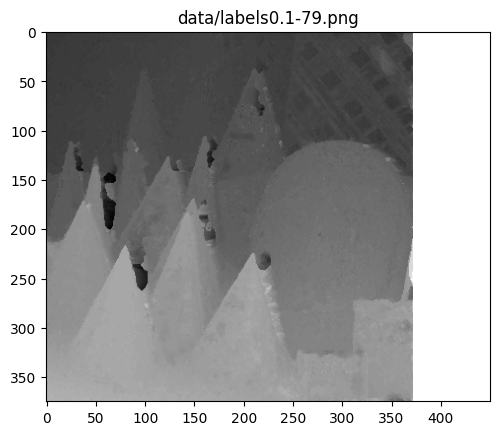

In [4]:
LAMBDAS = [0.1]
for lam in LAMBDAS:
    fp = numpy.zeros(shape=(disparity_max,disparity_max))
    for i in range(disparity_max):
        for j in range(i + 1,disparity_max):
            if i!= j:
                fp[i, j] = abs(i-j) * lam
                fp[j, i] = fp[i, j]
    labels = pygco.cut_grid_graph_simple(unary_cost=unary_cost, pairwise_cost=fp, connect=8)
    labels = labels.reshape(unary_cost.shape[0], unary_cost.shape[1])
    img_path = f"data/labels{lam}-{disparity_max}.png"
    matplotlib.pyplot.title(img_path)
    matplotlib.pyplot.imshow(X=labels, cmap='gray') 
    matplotlib.pyplot.show()


# The above is my best result, it is achieved under the params:
## weight of prior term(λ): 0.1
## using the max of disparity is 79 = 53 * 1.5

# problem:
## The edges of objects in my depth image are not as clear as in the CA example.
This may be because of the use of prior terms, which may be relatively larger than it in the CA example.
## There are some black blocks, whcih may be noises, in my depth image surrounding some cylinders
One of cause is that some are the backgrounds, which are only displayed in one image and occluded in the other image.
In this case, our codes can not compute its depth correctly.

In part 4, bundle optimization can solve this problem.
